In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OpticalElement:
    def __init__(self, elementName, dielectric=False, radius=0, distance=0, n=1, n2=0, focalLength=0, r1 = 0, r2 = 0, enterIndex = 0, exitIndex = 0):
        self.elementName = elementName
        self.dielectric = dielectric
        self.radius = radius
        self.distance = distance
        self.n = n
        self.n2 = n2
        self.focalLength = focalLength
        self.r1 = r1
        self.r2 = r2
        self.enterIndex = enterIndex
        self.exitIndex = exitIndex

    def rayMat(self):
        if self.elementName == "space":  # free space
            return np.array([[1, self.distance / self.n], [0, 1]])
        elif self.elementName == "thinLens":
            return np.array([[1, 0], [-1 / self.focalLength, 1]])
        elif self.elementName == "sphericalMirror":
            return np.array([[1, 0], [-2 / self.radius, 1]])
        elif self.elementName == "sphericalDielectric":
            return np.array([[1, 0], [((self.n2 - self.n) / self.n2) * (1 / self.radius), self.n / self.n2]])
        elif self.elementName == "opticalResonator":
            return np.array([[1, self.distance], [-1 / self.focalLength, 1 - (self.distance / self.focalLength)]])
        elif self.elementName == "diffract":
            return np.array([[1,0],[0, self.enterIndex/self.exitIndex]])
        elif self.elementName == "mirrorLens":
            return np.array([[1,0],[(self.exitIndex - self.enterIndex)/(self.radius*self.enterIndex), (self.exitIndex)/(self.enterIndex)]])
        else:
            raise ValueError("Optical element not supported")

    def distance(self):
        return self.distance

    def name(self):
        return self.elementName

    def reflecCoeffs(self):
        return self.r1, self.r2

class GaussianBeam:
    def __init__(self, rOfCurve, beamSpotSize, n, waveLength):
        self.rOfCurve = rOfCurve
        self.beamSpotSize = beamSpotSize
        self.n = n
        self.waveLength = waveLength
        self.q = self.calculate_q()
        self.vec = self.beamVector()

    def calculate_q(self):
        R = self.rOfCurve
        w = self.beamSpotSize
        lamb = self.waveLength
        q = 1 / ((1 / R) - ((1j * lamb) / (np.pi * self.n * w**2)))
        if np.imag(1 / q) >= 0:
            raise ValueError(f"Invalid initial q value: {q}")
        return q

    def updateQ(self, rayMat):
        q = self.q
        newQ = (rayMat[0][0] * q + rayMat[0][1]) / (rayMat[1][0] * q + rayMat[1][1])
        if np.imag(1 / newQ) >= 0:
            raise ValueError(f"Invalid updated q value encountered: {newQ}")
        self.q = newQ
        return newQ

    def beamVector(self):
        vec = np.array([self.q, 1])
        self.vec = vec
        return vec

    def beamSS(self, prevRad, distance):
        z = distance
        # w = prevRad * (np.sqrt(1+((self.waveLength*z)/(np.pi*prevRad**2))))
        w = np.sqrt(-1 / (np.imag(1 / self.q) * np.pi * self.n / self.waveLength))
        #w = np.sqrt(self.waveLength * np.absolute(np.imag(self.q))/np.pi)
        return w

    def initialW(self):
        return self.beamSpotSize

    def Q(self):
        return self.q

class Ray:
    def __init__(self, height, angle):
        self.height = height
        self.angle = angle

    def rayVector(self):
        return np.array([self.height, self.angle])

def plotRay(elements, initialBeam, beamType="ray"):
    positions = [0]
    heights = [initialBeam[0].real if beamType == "gaussianBeam" else initialBeam[0]]
    iLabel = "Initial Beam: Height = " + str(initialBeam[0]) + " Angle = " + str(initialBeam[1])
    labels = [iLabel]

    currentPosition = 0
    currentBeam = initialBeam

    for elem in elements:
        rayMatrix = elem.rayMat()
        currentBeam = beamPropagation([rayMatrix], currentBeam, beamType)

        if elem.elementName == "space":
            currentPosition += elem.distance
        elif elem.elementName == "sphericalMirror":
            currentBeam[1] = -currentBeam[1]  # Reflect the angle

        positions.append(currentPosition)
        heights.append(currentBeam[0].real if beamType == "gaussianBeam" else currentBeam[0])
        labels.append(elem.elementName)

    fLabel = "Final Beam: Height = " + str(np.round(currentBeam[0])) + " Angle = " + str(currentBeam[1])
    labels.append(fLabel)

    positions.append(currentPosition)
    heights.append(currentBeam[0].real if beamType == "gaussianBeam" else currentBeam[0])
    
    plt.figure(figsize=(10, 6))
    plt.plot(positions, heights, marker='o')
    for i, label in enumerate(labels):
        if label != "space":
            plt.annotate(label, (positions[i], heights[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.xlabel("Position along optical axis")
    plt.ylabel("Beam height")
    plt.title("Beam Propagation through Optical Elements")
    plt.grid()
    plt.show()

def plotBeam(elements, initialBeam, inc):
    diff = 0
    positions = [0]
    beamRadii = [initialBeam.initialW()]
    labels = ["Initial Beam, Beam Waist: " + str(np.round(initialBeam.initialW(), 5))]

    currentPosition = 0
    beam = initialBeam

    for elem in elements:
        if elem.elementName == "space":
            total = 0
            dist = elem.distance
            inc = inc

            while total < dist:
                el = OpticalElement("space", distance=inc)
                rayMatrix = el.rayMat()
                beam.updateQ(rayMatrix)
                currentPosition += el.distance
                positions.append(currentPosition)
                prevRad = beamRadii[-1]
                beamRadii.append(beam.beamSS(prevRad, inc))
                labels.append(elem.elementName)
                total += inc
        else:
            rayMatrix = elem.rayMat()
            beam.updateQ(rayMatrix)
            positions.append(currentPosition)
            labels.append(elem.elementName)
            beamRadii.append(beamRadii[-1])

    fLabel = "Final Beam: Beam Waist = " + str(np.round(beamRadii[-1], 5))
    labels.append(fLabel)
    positions.append(currentPosition)
    beamRadii.append(beamRadii[-1])

    plt.figure(figsize=(10, 6))
    
  
    for i in range(1, len(positions)):
        z = np.linspace(positions[i-1], positions[i], 1000)
        w = np.full_like(z, beamRadii[i])
        plt.plot(z, w, label='_nolegend_')
        plt.plot(z, -w, label='_nolegend_')
        
    for i, label in enumerate(labels):
        if label != "space" and label != "diffract": #and label != "sphericalMirror":
            plt.annotate(label, (positions[i], beamRadii[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('z (Propagation distance)')
    plt.ylabel('Beam radius')
    plt.title('Gaussian Beam Propagation')
    plt.grid(True)
    plt.show()

def finesse(opticalElement):
    B = 0.9993
    r1, r2, = opticalElement.reflecCoeffs()
    finesse = ((np.pi*B*np.sqrt(r1*r2))/(1-((B**2)*r1*r2)))
    print("The finesse of the cavity is:", finesse)
    return finesse

def lockCheck(cavityDistance, wavelength):
    k = 1/wavelength
    phi = k*cavityDistance
    if ((phi%(2*np.pi))/np.pi)%1 == 0:
        print("Laser locked!")
    else:
        print("Laser not locked.")


def stabilityCheck(opticalElement):
            g = np.trace(opticalElement.rayMat()) / 2
            eRayVals = [g + 1j * np.sqrt(1 - g * g), g - 1j * np.sqrt(1 - g * g)]
            if g * g <= 1:
                print("This is a stable resonator")
            else:
                print("This is not a stable resonator")
            print("Eigenray values of resonator:", eRayVals[0], eRayVals[1])

def beamPropogation(rayMatArr, beamVec, beamType):
    propMat = np.identity(2)
    q_initial = beamVec[0]
    dist  = len(rayMatArr)-1
    for i in range(dist+1):
        propMat = np.matmul(rayMatArr[(i)], propMat)
        
    if beamType == "gaussianBeam":
        #print("Abcd matrix:",propMat)
        q_final = (propMat[0][0] * q_initial + propMat[0][1]) / (propMat[1][0] * q_initial + propMat[1][1])

    return np.array([q_final, 1])


The finesse of the cavity is: 531.6942401681268
Laser not locked.
Done
beam waist: 0.19862175950035352


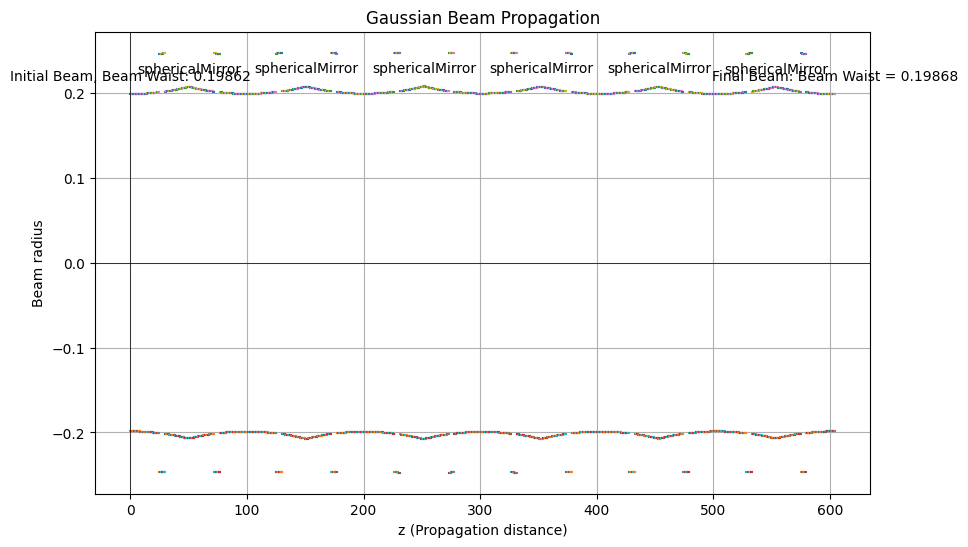

In [3]:
# EXAMPLE USAGE, OPTICS INTO FABRY PEROT CAVITY, ALL IN mm

res = OpticalElement("opticalResonator", distance = 100, focalLength = 300, r1 = 0.996, r2 = 0.9995)
finesse(res)
lockCheck(100, 0.000759)

L = 100
windowThickness = 5
windowDistance = 24.14

#cavity system
cavity = [
    OpticalElement("space", distance= windowDistance),
    
    OpticalElement("diffract", enterIndex = 1, exitIndex = 1.5),
    OpticalElement("space", distance= windowThickness),
    OpticalElement("diffract", enterIndex = 1.5, exitIndex = 1),
    
    OpticalElement("space", distance= ((L/2)-windowDistance-windowThickness)),
    
    OpticalElement("sphericalMirror", radius = 600),
    
    OpticalElement("space", distance= ((L/2)-windowDistance-windowThickness)),
    
    OpticalElement("diffract", enterIndex = 1, exitIndex = 1.5),
    OpticalElement("space", distance= windowThickness),
    OpticalElement("diffract", enterIndex = 1.5, exitIndex = 1),
    
    OpticalElement("space", distance= (windowDistance*2)),
    
    OpticalElement("diffract", enterIndex = 1, exitIndex = 1.5),
    OpticalElement("space", distance= windowThickness),
    OpticalElement("diffract", enterIndex = 1.5, exitIndex = 1),
    
    OpticalElement("space", distance= ((L/2)-windowDistance-windowThickness)),
    
    OpticalElement("sphericalMirror", radius = 600),
    
    OpticalElement("space", distance= ((L/2)-windowDistance-windowThickness)),
    
    OpticalElement("diffract", enterIndex = 1, exitIndex = 1.5),
    OpticalElement("space", distance= windowThickness),
    OpticalElement("diffract", enterIndex = 1.5, exitIndex = 1),
    
    OpticalElement("space", distance= (windowDistance)),

    # OpticalElement("space", distance 
]

iD = 11
elements = [

    OpticalElement("space", distance = iD),
    OpticalElement("thinLens", focalLength = iD),
    OpticalElement("space", distance = 240),
    OpticalElement("thinLens", focalLength = 500),
    OpticalElement("space", distance = 500+80),
    OpticalElement("thinLens", focalLength = 75),
    OpticalElement("space", distance = 40),
    OpticalElement("thinLens", focalLength = -300),
    # OpticalElement("sphericalMirror", radius = -600), same as thinLens in reverse!


    OpticalElement("space", distance= ((L/2)-windowDistance-windowThickness)),
    OpticalElement("diffract", enterIndex = 1, exitIndex = 1.5),
    OpticalElement("space", distance= windowThickness),
    OpticalElement("diffract", enterIndex = 1.5, exitIndex = 1),
    OpticalElement("space", distance= (windowDistance)),
]


passes = 5
for _ in range(passes):
    for e in cavity:
        elements.append(e)

#add increment of plotting scale
inc = 0.5

eles=[]
for o in elements:
    eles.append(o.rayMat())

#EVERYTHING IN MM
lambd = 0.000759

indexOfRefraction = 1

w0 = 0.00255
z = 0.0000000001 #distance from origin to first "element"

rayleighRange = ((np.pi)*(w0**2)*(indexOfRefraction))/(lambd)

radiusOfCurvature = z*(1 + ((rayleighRange/z)**2))

initial_gaussian_beam = GaussianBeam(rOfCurve=radiusOfCurvature, beamSpotSize=w0 , n=indexOfRefraction, waveLength=lambd)

#quality check, beam prop calc only matricies
waist = np.sqrt(-1 / (np.imag(1 / beamPropogation(eles, initial_gaussian_beam.beamVector(), "gaussianBeam")[0] * np.pi * 1 / 0.000759)))
print("beam waist:",waist)

plotBeam(elements, initial_gaussian_beam, inc)